In [72]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate,cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
from skimpy import skim
import optuna
import optuna.integration.lightgbm as lgb
from scipy import stats


In [73]:
sub = pd.read_csv("datasets/submission.csv")
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
hava = pd.read_csv("datasets/weather_data_ilce.csv")

In [74]:
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce = pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[0].iloc[:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'İLÇE','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'İLÇE','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['İLÇE']=ilce_nufus['İLÇE'].apply(unidecode).str.lower()

train['İL'] = train['İL'].apply(unidecode).str.lower()
train['İLÇE'] = train['İLÇE'].apply(unidecode).str.lower()

train=pd.merge(train,ilce_nufus,on=['İLÇE'],how='left')
train["ilce_nufus"] = train["ilce_nufus"].astype(float)

test['İL'] = test['İL'].apply(unidecode).str.lower()
test['İLÇE'] = test['İLÇE'].apply(unidecode).str.lower()

test=pd.merge(test,ilce_nufus,on=['İLÇE'],how='left')
test["ilce_nufus"] = test["ilce_nufus"].astype(float)


functions

In [75]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def outlier_thresholds(dataframe, col_name,q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 -quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit,up_limit


def check_outlier(dataframe,col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def remove_outlier(dataframe, col_name,q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name,q1,q3)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def grab_col_names(dataframe, cat_th=10, car_th=20):

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].dtype == "O" and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].dtype != "O" and dataframe[col].nunique() < cat_th]

    num_cols = num_cols + cat_but_car
    num_cols = [col for col in num_cols if col not in num_but_cat]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return num_cols, cat_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean().sort_values()}), end="\n\n\n")
    


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

def target_graph_with_cat(dataframe,column,target):
    nuni = dataframe[column].nunique()
    uni = dataframe[column].unique()

    plots = nuni+1
    rowsize = nuni+4
    fig, axs = plt.subplots(plots, figsize=(9,rowsize))
    fig.suptitle(f'{column} VE {target}')

    row = 1
    
    axs[0].plot(dataframe[target] )
    axs[0].set_title(target)
    
    for i in uni:
        ax = row

        axs[ax].set_title(i)
        c = [1  if o==i else 0 for o in dataframe[column]]
        axs[ax].plot(c)
        
        row +=1
        
    fig.tight_layout() 

In [76]:
num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 105392
Variables: 30
cat_cols: 8
num_cols: 22
cat_but_car: 5
num_but_cat: 2


<AxesSubplot:>

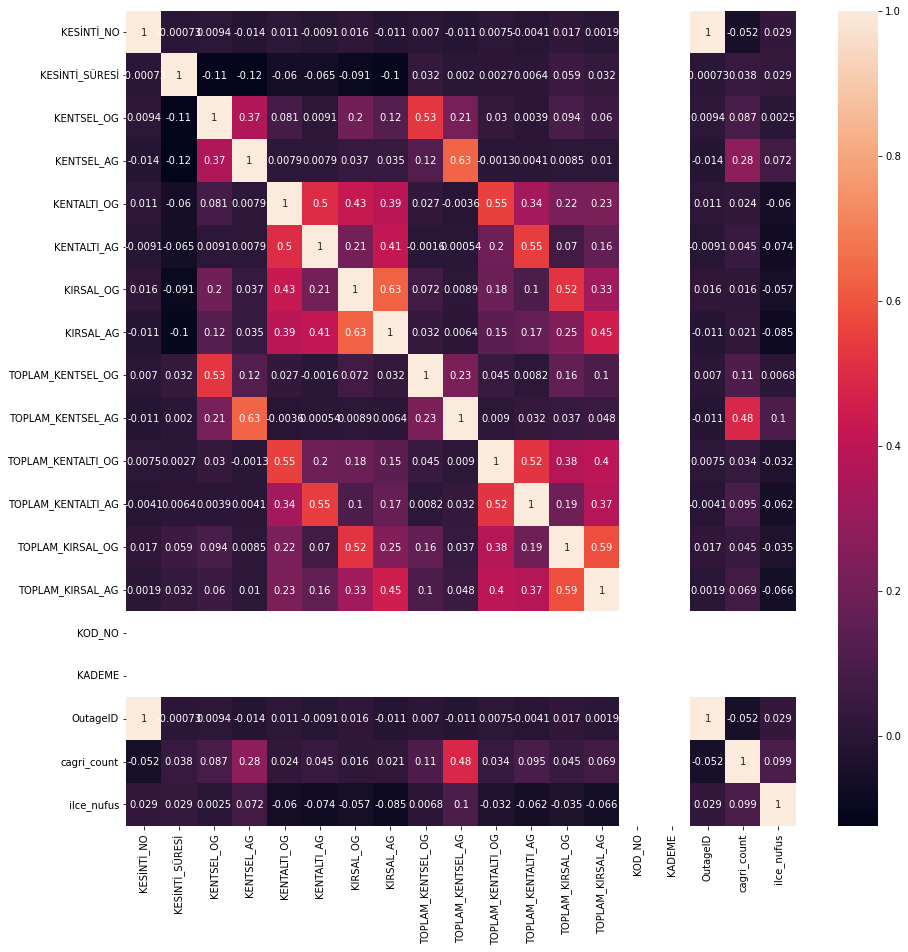

In [77]:
corr = train.corr()
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr,annot=True)


In [78]:
train["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
train["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(train["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)

test["BAŞLAMA_TARİHİ_VE_ZAMANI"] = pd.to_datetime(test["BAŞLAMA_TARİHİ_VE_ZAMANI"],dayfirst=True)
test["SONA_ERME_TARİHİ_VE_ZAMANI"] = pd.to_datetime(test["SONA_ERME_TARİHİ_VE_ZAMANI"],dayfirst=True)


In [79]:
train["baslama_hour"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
train["baslama_day"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
train["baslama_dayofweek"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["baslama_dayofyear"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week


train["bitis_hour"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
train["bitis_day"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
train["bitis_dayofweek"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
train["bitis_dayofyear"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week

test["baslama_hour"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.hour
test["baslama_day"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.day
test["baslama_dayofweek"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofweek
test["baslama_dayofyear"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.dayofyear
test["baslama_week"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week

test["bitis_hour"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.hour
test["bitis_day"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.day
test["bitis_dayofweek"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofweek
test["bitis_dayofyear"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.dayofyear
test["bitis_week"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week

C:\Users\talha\AppData\Local\Temp\ipykernel_23924\4089386461.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["baslama_week"] = train["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_23924\4089386461.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train["bitis_week"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_23924\4089386461.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test["baslama_week"] = test["BAŞLAMA_TARİHİ_VE_ZAMANI"].dt.week
C:\Users\talha\AppData\Local\Temp\ipykernel_23924\4089386461.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test["bitis_week"] = 

In [80]:
zeros = train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum()
zeros = pd.DataFrame(zeros)
zeros[zeros["cagri_count"] == 0]

,cagri_count
BAŞLAMA_TARİHİ_VE_ZAMANI,
2022-03-24,0.0
2022-03-25,0.0
2022-03-26,0.0
2022-03-27,0.0
2022-03-28,0.0
...,...
2022-06-08,0.0
2022-06-09,0.0
2022-06-10,0.0


In [81]:
train = train[train["BAŞLAMA_TARİHİ_VE_ZAMANI"] < "2022-03-24"].reset_index(drop=True)
#train.set_index("BAŞLAMA_TARİHİ_VE_ZAMANI").resample("D")["cagri_count"].sum().plot();

column drop

In [82]:
train.drop(["KOD_NO","KADEME"],axis=1,inplace=True)
train.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)
train.drop("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",axis=1,inplace=True)
train.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)
train.drop("KESİNTİ_NO",axis=1, inplace=True)
train.drop("OutageID",axis=1,inplace=True)
train.drop("SÜREYE_GÖRE", axis=1, inplace=True)

test.drop("KADEME",axis=1,inplace=True)
test.drop("ŞEBEKE_UNSURU_KODU",axis=1,inplace=True)
test.drop("KESİNTİ_NEDENİNE_İLİŞKİN_AÇIKLAMA",axis=1,inplace=True)
test.drop("BİLDİRİME_GÖRE",axis=1,inplace=True)
test.drop("KESİNTİ_NO",axis=1, inplace=True)
test.drop("OutageID",axis=1,inplace=True)
test.drop("SÜREYE_GÖRE", axis=1, inplace=True)

cat cols analyze

In [83]:
target_summary_with_cat(train,"cagri_count","ŞEBEKE_UNSURU")

                           TARGET_MEAN
ŞEBEKE_UNSURU                         
Abone Tesisi                  1.579841
AG Fideri                     6.829145
Saha Dağıtım Kutusu (SDK)     9.072140
Dağıtım Transformatörü       10.050094
KÖK                          10.271268
OG Fideri                    15.596047
DM                           18.959956
TM Fideri                    54.970219




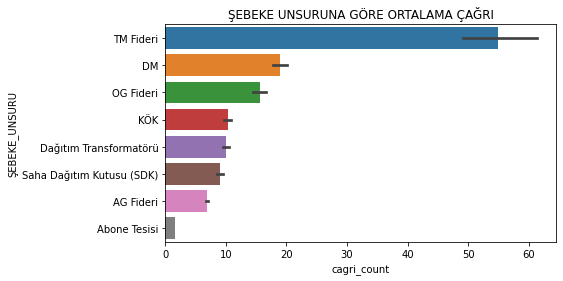

In [84]:
asc_order =train.groupby('ŞEBEKE_UNSURU')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(7,4))
sns.barplot(data=train,x="cagri_count",y="ŞEBEKE_UNSURU",order=asc_order, orient="horizontal")
ax.set_title("ŞEBEKE UNSURUNA GÖRE ORTALAMA ÇAĞRI");

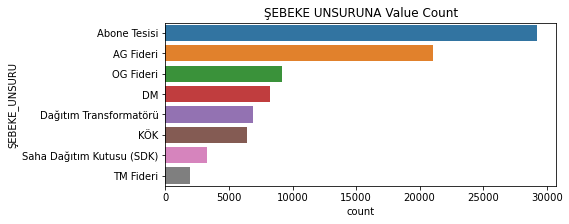

In [85]:
large_to_small = train.groupby('ŞEBEKE_UNSURU').size().sort_values().index[::-1]
fig,ax = plt.subplots(figsize=(7,3))
ax = sns.countplot(data=train, y="ŞEBEKE_UNSURU", order=large_to_small,orient="horizontal")
ax.set_title("ŞEBEKE UNSURUNA Value Count");

In [86]:
target_summary_with_cat(train,"cagri_count","KAYNAĞA_GÖRE")

              TARGET_MEAN
KAYNAĞA_GÖRE             
Dağıtım-AG       4.781445
Dağıtım-OG      17.818462
İletim          40.807453




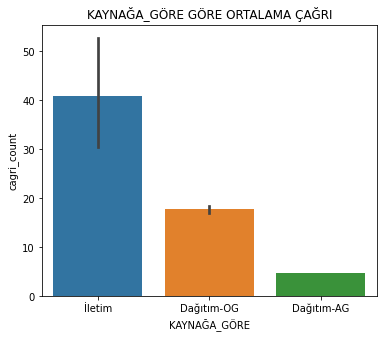

In [87]:
asc_order =train.groupby('KAYNAĞA_GÖRE')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(6,5))
sns.barplot(data=train,x="KAYNAĞA_GÖRE",y="cagri_count",order=asc_order);
ax.set_title("KAYNAĞA_GÖRE GÖRE ORTALAMA ÇAĞRI");

In [88]:
target_summary_with_cat(train,"cagri_count","SEBEBE_GÖRE")

                    TARGET_MEAN
SEBEBE_GÖRE                    
Şebeke işletmecisi     8.348295
Dışsal                30.003028
Güvenlik              52.193182




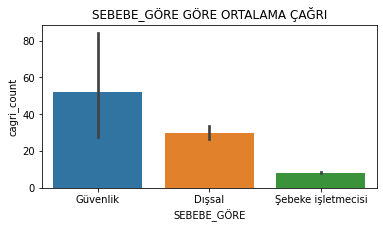

In [89]:
asc_order =train.groupby('SEBEBE_GÖRE')['cagri_count'].mean().sort_values(ascending=False).index.values
fig,ax = plt.subplots(figsize=(6,3))
sns.barplot(data=train,x="SEBEBE_GÖRE",y="cagri_count",order=asc_order);
ax.set_title("SEBEBE_GÖRE GÖRE ORTALAMA ÇAĞRI");

In [90]:
num_cols, cat_cols, cat_but_car = grab_col_names(train)

Observations: 86268
Variables: 32
cat_cols: 6
num_cols: 26
cat_but_car: 1
num_but_cat: 2


rare analyze

In [91]:
rare_analyser(train,"cagri_count",cat_cols)

İL : 2
        COUNT     RATIO  TARGET_MEAN
izmir   59277  0.687126     9.832110
manisa  26991  0.312874     6.557112


ŞEBEKE_UNSURU : 8
                           COUNT     RATIO  TARGET_MEAN
AG Fideri                  21053  0.244042     6.829145
Abone Tesisi               29258  0.339152     1.579841
DM                          8216  0.095238    18.959956
Dağıtım Transformatörü      6887  0.079833    10.050094
KÖK                         6418  0.074396    10.271268
OG Fideri                   9209  0.106749    15.596047
Saha Dağıtım Kutusu (SDK)   3313  0.038404     9.072140
TM Fideri                   1914  0.022187    54.970219


KAYNAĞA_GÖRE : 3
            COUNT     RATIO  TARGET_MEAN
Dağıtım-AG  60479  0.701059     4.781445
Dağıtım-OG  25306  0.293342    17.818462
İletim        483  0.005599    40.807453


SEBEBE_GÖRE : 3
                    COUNT     RATIO  TARGET_MEAN
Dışsal               1651  0.019138    30.003028
Güvenlik               88  0.001020    52.193182
Şebeke işl

In [92]:
tmp = train.groupby("ŞEBEKE_UNSURU")["cagri_count"].mean()
rare_labels = tmp[tmp < 10].index
train["ŞEBEKE_UNSURU"] = np.where(train["ŞEBEKE_UNSURU"].isin(rare_labels), 'Rare', train["ŞEBEKE_UNSURU"])

test["SEBEBE_GÖRE"][test["SEBEBE_GÖRE"] == "0"] = "Dışsal"
rare_labels = ['AG Fideri', 'Abone Tesisi', 'Saha Dağıtım Kutusu (SDK)']
test["ŞEBEKE_UNSURU"] = np.where(test["ŞEBEKE_UNSURU"].isin(rare_labels), 'Rare', test["ŞEBEKE_UNSURU"])

C:\Users\talha\AppData\Local\Temp\ipykernel_23924\3741898290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["SEBEBE_GÖRE"][test["SEBEBE_GÖRE"] == "0"] = "Dışsal"


corr analyze

<AxesSubplot:xlabel='cagri_count', ylabel='index'>

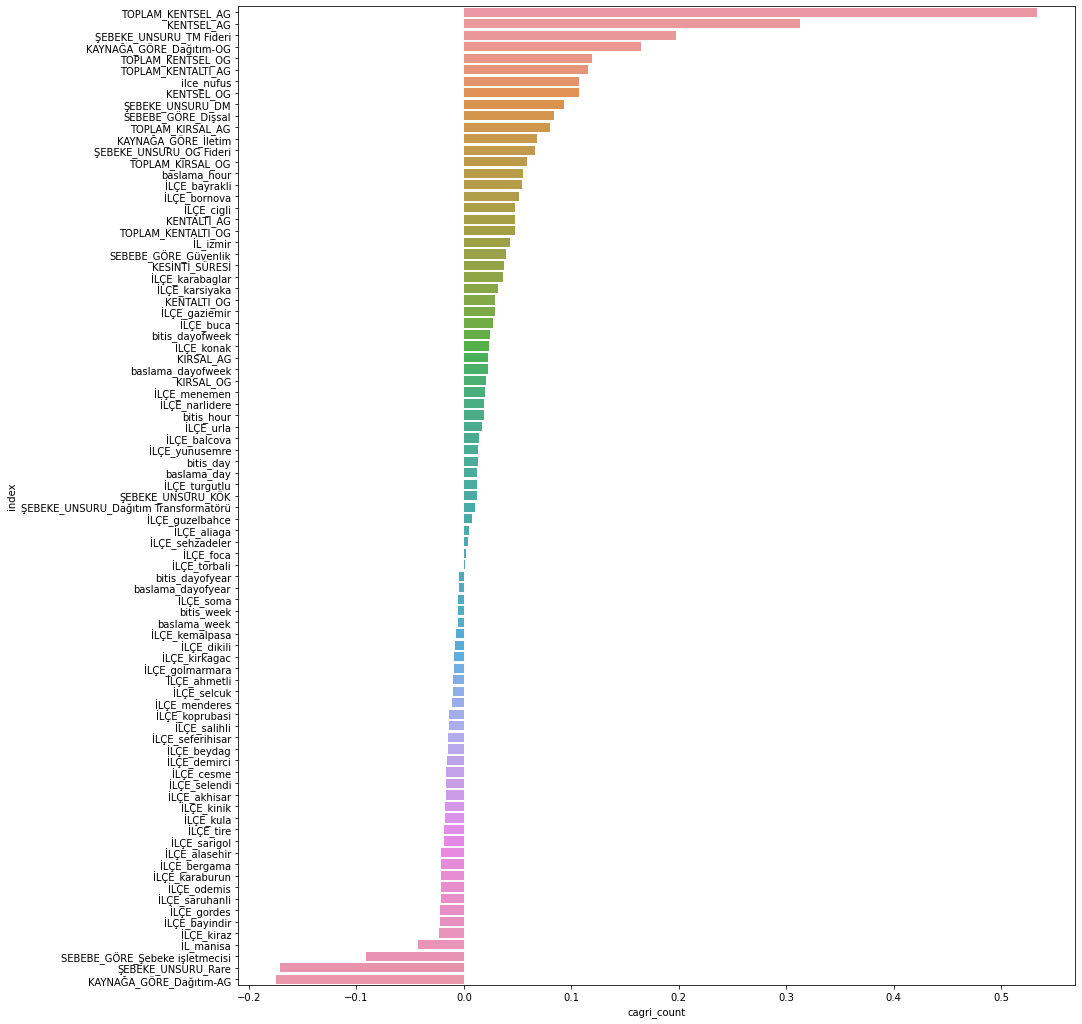

In [93]:
train_du = pd.get_dummies(train)

corr = train_du.corr()
data=corr["cagri_count"].sort_values(ascending=False)
data =pd.DataFrame(data)
data = data.reset_index()
data = data[data["index"]!="cagri_count"]

fig,ax=plt.subplots(figsize=(15,18))
sns.barplot(data=data, x=data["cagri_count"],y=data["index"] , orient="horizontal")

num cols analyze

In [94]:
train["KESİNTİ_SÜRESİ"].describe().T

count    86268.000000
mean         2.409280
std          2.744538
min          0.000278
25%          0.941944
50%          1.740278
75%          3.081736
max        289.323333
Name: KESİNTİ_SÜRESİ, dtype: float64

<AxesSubplot:ylabel='Frequency'>

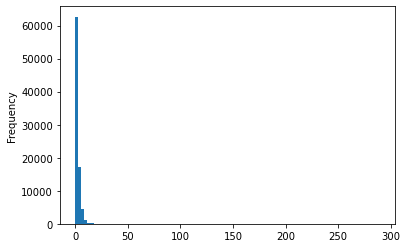

In [95]:
train["KESİNTİ_SÜRESİ"].plot(kind="hist",bins=100)

In [96]:
print(stats.shapiro(train["KESİNTİ_SÜRESİ"]))

ShapiroResult(statistic=0.5838581919670105, pvalue=0.0)


c:\Users\talha\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<AxesSubplot:xlabel='KESİNTİ_SÜRESİ'>

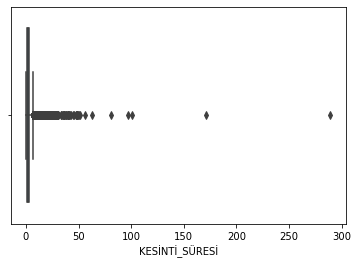

In [97]:
sns.boxplot(data=train,x="KESİNTİ_SÜRESİ")

In [98]:
num_cols,cat_cols,cat_but_car = grab_col_names(train)

Observations: 86268
Variables: 32
cat_cols: 6
num_cols: 26
cat_but_car: 1
num_but_cat: 2


In [99]:
num_cols

['BAŞLAMA_TARİHİ_VE_ZAMANI',
 'SONA_ERME_TARİHİ_VE_ZAMANI',
 'KESİNTİ_SÜRESİ',
 'KENTSEL_OG',
 'KENTSEL_AG',
 'KENTALTI_OG',
 'KENTALTI_AG',
 'KIRSAL_OG',
 'KIRSAL_AG',
 'TOPLAM_KENTSEL_OG',
 'TOPLAM_KENTSEL_AG',
 'TOPLAM_KENTALTI_OG',
 'TOPLAM_KENTALTI_AG',
 'TOPLAM_KIRSAL_OG',
 'TOPLAM_KIRSAL_AG',
 'cagri_count',
 'ilce_nufus',
 'baslama_hour',
 'baslama_day',
 'baslama_dayofyear',
 'baslama_week',
 'bitis_hour',
 'bitis_day',
 'bitis_dayofyear',
 'bitis_week',
 'İLÇE']

In [100]:
num_cols = ['KESİNTİ_SÜRESİ',
 'KENTSEL_OG',
 'KENTSEL_AG',
 'KENTALTI_OG',
 'KENTALTI_AG',
 'KIRSAL_OG',
 'KIRSAL_AG',
 'TOPLAM_KENTSEL_OG',
 'TOPLAM_KENTSEL_AG',
 'TOPLAM_KENTALTI_OG',
 'TOPLAM_KENTALTI_AG',
 'TOPLAM_KIRSAL_OG',
 'TOPLAM_KIRSAL_AG']

In [101]:
train_t = train.copy()

In [102]:
num_cols = ['maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'moon_illumination',
 'DewPointC',
 'FeelsLikeC',
 'HeatIndexC',
 'WindChillC',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'tempC',
 'visibility',
 'winddirDegree',
 'windspeedKmph',
 ]

In [103]:
for col in num_cols:
   a = train['cagri_count'].corr(hava[col])
   a = abs(a)
   if a > 0.015:
      print(col,a)
    

maxtempC 0.018412260757288555
mintempC 0.029531460570493894
sunHour 0.027178995235316868
DewPointC 0.02922157986217342
FeelsLikeC 0.019801061657343185
HeatIndexC 0.019408196232202933
WindChillC 0.019492490006634784
WindGustKmph 0.016660251980573557
tempC 0.018513736928039082


<AxesSubplot:xlabel='TOPLAM_KIRSAL_AG', ylabel='Count'>

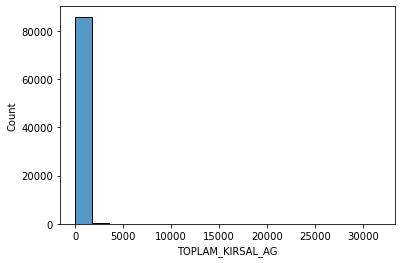

In [104]:
sns.histplot(data=train, x="TOPLAM_KIRSAL_AG")

<AxesSubplot:xlabel='KESİNTİ_SÜRESİ', ylabel='Count'>

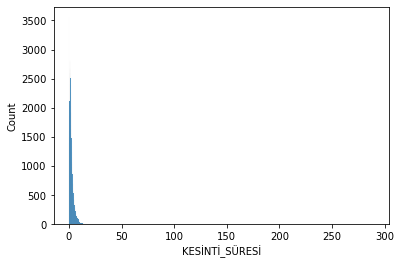

In [105]:
sns.histplot(data=train_t, x="KESİNTİ_SÜRESİ")

In [106]:
train["KESİNTİ_SÜRESİ_DK"] = train["SONA_ERME_TARİHİ_VE_ZAMANI"] - train["BAŞLAMA_TARİHİ_VE_ZAMANI"]
train['KESİNTİ_SÜRESİ_DK'] = train['KESİNTİ_SÜRESİ_DK'].dt.total_seconds()/60
train.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)

test["KESİNTİ_SÜRESİ_DK"] = test["SONA_ERME_TARİHİ_VE_ZAMANI"] - test["BAŞLAMA_TARİHİ_VE_ZAMANI"]
test['KESİNTİ_SÜRESİ_DK'] = test['KESİNTİ_SÜRESİ_DK'].dt.total_seconds()/60
test.drop(["BAŞLAMA_TARİHİ_VE_ZAMANI","SONA_ERME_TARİHİ_VE_ZAMANI"],axis=1,inplace=True)


<AxesSubplot:xlabel='baslama_hour', ylabel='KESİNTİ_SÜRESİ_DK'>

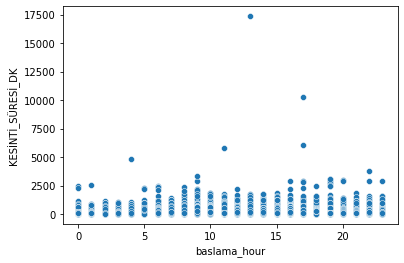

In [107]:
sns.scatterplot(data=train, x="baslama_hour", y="KESİNTİ_SÜRESİ_DK")

In [108]:
train["baslama_hour"].corr(train["KESİNTİ_SÜRESİ_DK"])

-0.01947349593938459

In [109]:
#train.groupby("İLÇE")["cagri_count"].sum().sort_values().plot(kind="bar")

In [110]:
train.drop("KESİNTİ_SÜRESİ", axis=1, inplace=True)
test.drop("KESİNTİ_SÜRESİ", axis=1, inplace=True)

In [111]:
train

,İL,İLÇE,ŞEBEKE_UNSURU,KAYNAĞA_GÖRE,SEBEBE_GÖRE,KENTSEL_OG,KENTSEL_AG,KENTALTI_OG,KENTALTI_AG,KIRSAL_OG,...,baslama_day,baslama_dayofweek,baslama_dayofyear,baslama_week,bitis_hour,bitis_day,bitis_dayofweek,bitis_dayofyear,bitis_week,KESİNTİ_SÜRESİ_DK
0,izmir,bornova,OG Fideri,Dağıtım-OG,Şebeke işletmecisi,3,1613,0,0,0,...,30,6,30,4,1,31,0,31,5,305.066667
1,izmir,bornova,OG Fideri,Dağıtım-OG,Şebeke işletmecisi,3,1613,0,0,0,...,31,0,31,5,5,31,0,31,5,103.750000
2,izmir,bornova,OG Fideri,Dağıtım-OG,Şebeke işletmecisi,14,15,0,0,0,...,12,5,43,6,9,12,5,43,6,87.966667
3,izmir,karabaglar,OG Fideri,Dağıtım-OG,Dışsal,8,2752,0,0,0,...,24,0,24,4,16,24,0,24,4,65.966667
4,izmir,seferihisar,OG Fideri,Dağıtım-OG,Şebeke işletmecisi,1,40,0,0,0,...,6,6,65,9,14,6,6,65,9,126.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86263,izmir,seferihisar,Rare,Dağıtım-AG,Şebeke işletmecisi,0,1,0,0,0,...,28,1,362,52,18,28,1,362,52,196.100000
86264,izmir,karaburun,Rare,Dağıtım-AG,Şebeke işletmecisi,0,1,0,0,0,...,26,6,360,51,16,26,6,360,51,63.416667
86265,manisa,akhisar,Rare,Dağıtım-AG,Şebeke işletmecisi,0,4,0,0,0,...,23,3,357,51,21,23,3,357,51,59.600000
86266,izmir,bornova,Rare,Dağıtım-AG,Şebeke işletmecisi,0,1,0,0,0,...,24,4,358,51,12,24,4,358,51,47.083333


In [112]:
num_cols,cat_cols,cat_but_car = grab_col_names(train)

Observations: 86268
Variables: 30
cat_cols: 6
num_cols: 24
cat_but_car: 1
num_but_cat: 2


In [113]:
num_cols
num_cols = ['KENTSEL_OG',
 'KENTSEL_AG',
 'KENTALTI_OG',
 'KENTALTI_AG',
 'KIRSAL_OG',
 'KIRSAL_AG',
 'TOPLAM_KENTSEL_OG',
 'TOPLAM_KENTSEL_AG',
 'TOPLAM_KENTALTI_OG',
 'TOPLAM_KENTALTI_AG',
 'TOPLAM_KIRSAL_OG',
 'TOPLAM_KIRSAL_AG',
 'ilce_nufus',
 'baslama_hour',
 'baslama_day',
 'baslama_dayofyear',
 'baslama_dayofweek',
 'baslama_week',
 'bitis_hour',
 'bitis_day',
 'bitis_dayofyear',
 'bitis_dayofweek',
 'bitis_week',
 'KESİNTİ_SÜRESİ_DK']

In [114]:
X_scaled = RobustScaler().fit_transform(train[num_cols])
train[num_cols] = pd.DataFrame(X_scaled, columns=train[num_cols].columns)

X_test_scaled = RobustScaler().fit_transform(test[num_cols])
test[num_cols] = pd.DataFrame(X_test_scaled, columns=test[num_cols].columns)

# Modelleme

In [115]:
train_dum = pd.get_dummies(train,drop_first=True)
test_dum = pd.get_dummies(test,drop_first=True)

In [47]:
y = train_dum["cagri_count"]
X = train_dum.drop("cagri_count",axis=1)

In [329]:
def base_reg_models(X, y, scoring="neg_root_mean_squared_error"):
    print("Base Regression Models....")
    regressors = [#('LR', LinearRegression()),
                  #("DT", DecisionTreeRegressor()),
                  #('GB', GradientBoostingRegressor(verbose=False)),
                  #('ADA', AdaBoostRegressor()),
                  ('XGB', XGBRegressor()),
                  ('LGBM', LGBMRegressor()),
                  ('CB', CatBoostRegressor(verbose=False))
                  ]

    for name, regressor in regressors:

        cv_result = np.mean(-cross_val_score(regressor, X, y, cv=5, scoring=scoring))

        print(f"{scoring}: {round(cv_result, 4)} ({name}) ")


base_reg_models(X, y)

# base
# neg_root_mean_squared_error: 25.4788 (XGB) 
# neg_root_mean_squared_error: 24.4293 (LGBM) 

# outlier lof drop sonrası v1 lgbm
# neg_root_mean_squared_error: 27.2338 (XGB) 
# neg_root_mean_squared_error: 26.2434 (LGBM) TEST 32.06191 5,82
# neg_root_mean_squared_error: 25.5409 (CB) 

# outlier 05-95 drop sonrası v2 lgbm
# neg_root_mean_squared_error: 11.6073 (XGB) 
# neg_root_mean_squared_error: 11.1107 (LGBM) TEST 40.71149

# outlier 01-99 drop sonrası v3 lgbm
# neg_root_mean_squared_error: 20.0292 (XGB) 
# neg_root_mean_squared_error: 18.9743 (LGBM) TEST 36.04529
# neg_root_mean_squared_error: 19.089 (CB)

# ilceler eklendi v4 lgbm
# neg_root_mean_squared_error: 25.8296 (XGB) 
# neg_root_mean_squared_error: 24.3372 (LGBM) 
# neg_root_mean_squared_error: 24.0947 (CB) 

# standard scaler v5 lgbm
# neg_root_mean_squared_error: 25.383 (XGB) 
# neg_root_mean_squared_error: 23.8611 (LGBM) test 31.73627
# neg_root_mean_squared_error: 23.9515 (CB) 

# minmax scaler v6 lgbm
# neg_root_mean_squared_error: 25.3812 (XGB) 
# neg_root_mean_squared_error: 24.3174 (LGBM) test 41.18170
# neg_root_mean_squared_error: 23.9477 (CB) 

# robust scaler v7 lgbm
# neg_root_mean_squared_error: 25.3843 (XGB) 
# neg_root_mean_squared_error: 24.1538 (LGBM) test 31.36007
# neg_root_mean_squared_error: 23.9477 (CB) 

# lof n=20 drop v8 lgbm
# neg_root_mean_squared_error: 25.4921 (XGB) 
# neg_root_mean_squared_error: 24.1154 (LGBM) test 32.88195

# scaler yok outlier drop yok v9 lgbm
# neg_root_mean_squared_error: 25.3864 (XGB) 
# neg_root_mean_squared_error: 24.3724 (LGBM) test  32.00316
# neg_root_mean_squared_error: 23.9494 (CB)  

# 0.05 rare encoding sonrası robust scaler ile v10 lgbm
# neg_root_mean_squared_error: 25.0578 (XGB) 
# neg_root_mean_squared_error: 24.0341 (LGBM) test 31.74405
# neg_root_mean_squared_error: 23.8399 (CB) 

# robust scaler + şebeke unsuru rare target mean e göre v11 lgbm
# neg_root_mean_squared_error: 25.3667 (XGB) 
# neg_root_mean_squared_error: 24.2715 (LGBM) test 31.07927
# neg_root_mean_squared_error: 24.0977 (CB) 

# robbust + şebeke,sebebegöre,kaynağagöre rare target mean e göre v12 lgbm
# neg_root_mean_squared_error: 25.5203 (XGB) 
# neg_root_mean_squared_error: 24.3333 (LGBM) test 31.43007
# neg_root_mean_squared_error: 24.3628 (CB) 

# robust scaler + şebeke rare target ile + ilcesiz v13 lgbm
# neg_root_mean_squared_error: 25.3531 (XGB) 
# neg_root_mean_squared_error: 24.3924 (LGBM) test 31.41534
# neg_root_mean_squared_error: 24.2901 (CB) 

Base Regression Models....
neg_root_mean_squared_error: 25.3667 (XGB) 
neg_root_mean_squared_error: 24.2715 (LGBM) 
neg_root_mean_squared_error: 24.0977 (CB) 


In [295]:
lgbm_params = { "colsample_bytree": 0.5,
                'max_depth': 8,
                'learning_rate': 0.01,
                'n_estimators': 3000,
                'max_bin': 160
                }

In [48]:
lgbm_params = {'n_estimators': 10000, 'learning_rate': 0.01616699441013903, 'num_leaves': 2560, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 7.566523961602559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lgbm = LGBMRegressor()
lgbm.set_params(**lgbm_params).fit(X_train,y_train)

y_pred = lgbm.predict(X_test)
print(round(np.sqrt(mean_squared_error(y_test, y_pred)),4))
# 24.393

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.566523961602559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.566523961602559
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
25.7533


In [54]:
def get_cv_result(model):
    cv_result = cross_val_score(model, X, y,
                                cv=5, scoring="neg_root_mean_squared_error",
                                verbose=2)
    print(-cv_result)
    print("RMSE: %0.2f (+/- %0.2f)" % (-cv_result.mean(), cv_result.std()))
    return model

In [154]:
model = CatBoostRegressor()
_ = get_cv_result(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.079934
0:	learn: 31.3804986	total: 162ms	remaining: 2m 41s
1:	learn: 30.6110038	total: 173ms	remaining: 1m 26s
2:	learn: 29.9573118	total: 185ms	remaining: 1m 1s
3:	learn: 29.3490881	total: 198ms	remaining: 49.3s
4:	learn: 28.7919031	total: 208ms	remaining: 41.5s
5:	learn: 28.2922407	total: 219ms	remaining: 36.2s
6:	learn: 27.8422813	total: 229ms	remaining: 32.4s
7:	learn: 27.4257527	total: 239ms	remaining: 29.6s
8:	learn: 27.0261840	total: 251ms	remaining: 27.6s
9:	learn: 26.7128399	total: 262ms	remaining: 26s
10:	learn: 26.4040650	total: 273ms	remaining: 24.5s
11:	learn: 26.0525301	total: 283ms	remaining: 23.3s
12:	learn: 25.7913159	total: 294ms	remaining: 22.3s
13:	learn: 25.5266359	total: 303ms	remaining: 21.4s
14:	learn: 25.3032820	total: 315ms	remaining: 20.7s
15:	learn: 25.0596201	total: 325ms	remaining: 20s
16:	learn: 24.8836294	total: 336ms	remaining: 19.4s
17:	learn: 24.6735577	total: 346ms	remaining: 18.9s
18:	learn: 24.4590221	total: 355ms	remaining: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


Learning rate set to 0.079934
0:	learn: 30.4727715	total: 58ms	remaining: 58s
1:	learn: 29.5823320	total: 68ms	remaining: 33.9s
2:	learn: 28.8951358	total: 76.8ms	remaining: 25.5s
3:	learn: 28.1104815	total: 87.5ms	remaining: 21.8s
4:	learn: 27.4422143	total: 97.5ms	remaining: 19.4s
5:	learn: 26.8582808	total: 107ms	remaining: 17.8s
6:	learn: 26.2845970	total: 117ms	remaining: 16.5s
7:	learn: 25.8044885	total: 125ms	remaining: 15.5s
8:	learn: 25.3506613	total: 135ms	remaining: 14.8s
9:	learn: 24.9889340	total: 144ms	remaining: 14.2s
10:	learn: 24.5895877	total: 153ms	remaining: 13.8s
11:	learn: 24.1850490	total: 162ms	remaining: 13.4s
12:	learn: 23.8360912	total: 171ms	remaining: 13s
13:	learn: 23.5039835	total: 181ms	remaining: 12.8s
14:	learn: 23.1749661	total: 191ms	remaining: 12.6s
15:	learn: 22.9082380	total: 201ms	remaining: 12.4s
16:	learn: 22.6614243	total: 210ms	remaining: 12.1s
17:	learn: 22.4152668	total: 219ms	remaining: 12s
18:	learn: 22.1664054	total: 228ms	remaining: 11.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   49.0s finished


In [155]:
models = []

for i in [42, 1337, 1773, 1234, 4321, 0, 255, 2021,22]:
    lgbm_params["random_seed"] = i
    model = model.fit(X, y)
    models.append(model)

Learning rate set to 0.082803
0:	learn: 34.2489196	total: 58.4ms	remaining: 58.3s
1:	learn: 33.3169159	total: 71.2ms	remaining: 35.5s
2:	learn: 32.4699463	total: 84.4ms	remaining: 28.1s
3:	learn: 31.8237351	total: 96ms	remaining: 23.9s
4:	learn: 31.1490273	total: 108ms	remaining: 21.4s
5:	learn: 30.5617518	total: 120ms	remaining: 19.9s
6:	learn: 30.0215723	total: 130ms	remaining: 18.5s
7:	learn: 29.5220954	total: 141ms	remaining: 17.5s
8:	learn: 29.0718286	total: 153ms	remaining: 16.8s
9:	learn: 28.6912389	total: 164ms	remaining: 16.2s
10:	learn: 28.2982910	total: 174ms	remaining: 15.7s
11:	learn: 27.9271499	total: 185ms	remaining: 15.2s
12:	learn: 27.5881909	total: 196ms	remaining: 14.9s
13:	learn: 27.3201157	total: 207ms	remaining: 14.6s
14:	learn: 27.0314263	total: 219ms	remaining: 14.4s
15:	learn: 26.7745304	total: 230ms	remaining: 14.1s
16:	learn: 26.5350703	total: 240ms	remaining: 13.9s
17:	learn: 26.3015993	total: 251ms	remaining: 13.7s
18:	learn: 26.0993186	total: 262ms	remaini

In [156]:
model_cols = list(X.columns)
test_dum["cagri_count"] = np.nan

train_test_stacked_df = pd.concat([train_dum, test_dum], axis=0).reset_index(drop=True)
preds = [model.predict(train_test_stacked_df[model_cols]) for model in models]
mean_preds = np.mean(preds, axis=0)

train_test_stacked_df.loc[:, 'cagri_count'] = np.maximum(np.zeros(len(train_test_stacked_df)), mean_preds)

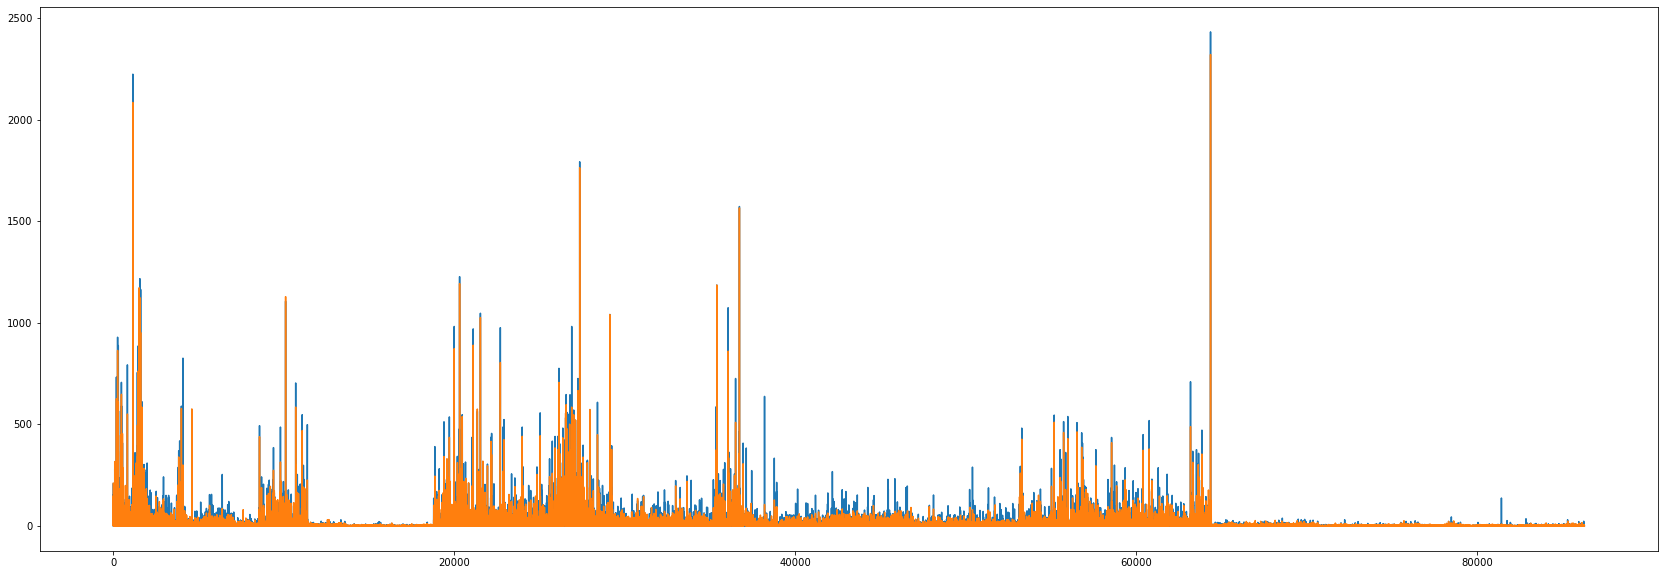

In [157]:
plt.figure(figsize=(29,10))
#train_test_stacked_df["cagri_count"][:].plot()
train_dum["cagri_count"][:].plot()
train_test_stacked_df["cagri_count"][:len(train_test_stacked_df)-16751].plot()

plt.show()

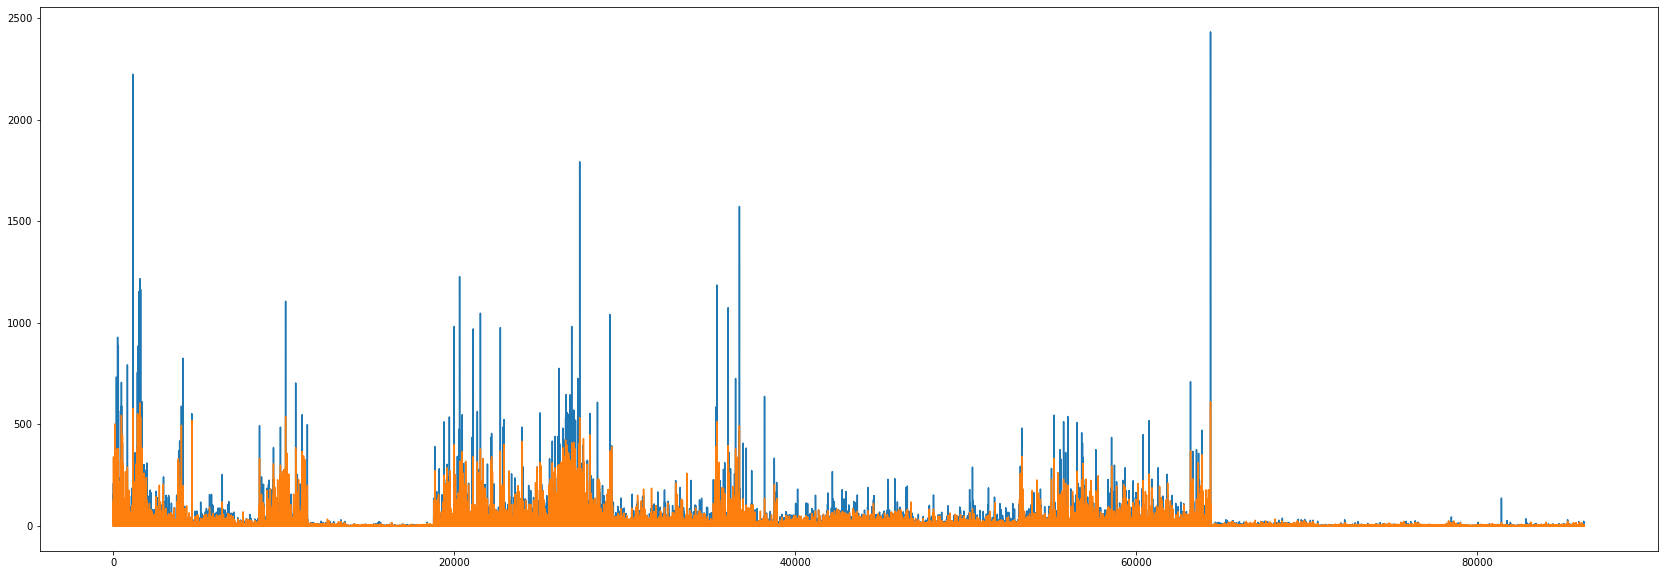

In [153]:
plt.figure(figsize=(29,10))
#train_test_stacked_df["cagri_count"][:].plot()
train_dum["cagri_count"][:].plot()
train_test_stacked_df["cagri_count"][:len(train_test_stacked_df)-16751].plot()

plt.show()

In [160]:
train_test_stacked_df["cagri_count"][len(train_dum):].sum()

162379.06145050612

<AxesSubplot:>

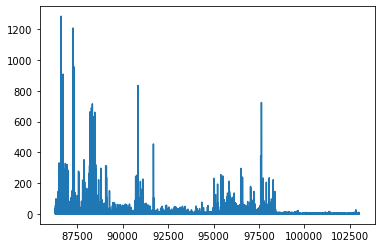

In [159]:
train_test_stacked_df["cagri_count"][len(train_dum):].plot()

In [161]:
sub["cagri_count"] = round(train_test_stacked_df["cagri_count"][len(train_dum):].reset_index(drop=True))

In [147]:
sub.to_csv("submission.csv", index=False)

In [50]:
joblib.dump(lgbm,"v14_lgbm.pkl")

['v14_lgbm.pkl']

## hiperparametre  optimizasyon

In [344]:
params = {'n_estimators': 10000, 'learning_rate': 0.01616699441013903, 'num_leaves': 2560, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 7.566523961602559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}

In [345]:
lgbm_final = lgbm.set_params(**params).fit(X, y)

cv_results = np.mean((-cross_val_score(lgbm_final, X, y, cv=5, scoring="neg_root_mean_squared_error")))

print(f"lgbm rmse {cv_results}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.566523961602559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.566523961602559
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500,

In [341]:
def objective(trial , data = X , target = y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.20 , random_state = 22)

    params = {
       "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    # Add a callback for pruning.
    model = LGBMRegressor(**params, tree_method = "gpu_hist",random_state=22)
    model.fit(X_train,y_train,eval_set = [(X_test,y_test)] , verbose = False , eval_metric = "rmse")

    y_preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))

    return rmse

In [342]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 30)
print("Number of finished trials:", len(study.trials))
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

[I 2022-09-13 17:12:52,682] A new study created in memory with name: no-name-4ecfa9d8-64fe-47bf-9a81-ff734a3c7a53
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=4.058821744031166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.058821744031166
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:13:09,135] Trial 0 finished with value: 26.545851311533827 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14568250484195636, 'num_leaves': 2240, 'max_depth': 3, 'min_data_in_leaf': 4900, 'lambda_l1': 95, 'lambda_l2': 70, 'min_gain_to_split': 4.058821744031166, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 26.545851311533827.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=3.1240440684729647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1240440684729647
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:13:31,864] Trial 1 finished with value: 26.307038067247735 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2991579754772398, 'num_leaves': 980, 'max_depth': 4, 'min_data_in_leaf': 4600, 'lambda_l1': 100, 'lambda_l2': 70, 'min_gain_to_split': 3.1240440684729647, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 26.307038067247735.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=0.4939158796405041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4939158796405041
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:13:40,576] Trial 2 finished with value: 32.58554708075041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12213081843500147, 'num_leaves': 2860, 'max_depth': 5, 'min_data_in_leaf': 7000, 'lambda_l1': 25, 'lambda_l2': 10, 'min_gain_to_split': 0.4939158796405041, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 26.307038067247735.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] min_gain_to_split is set=2.24702331045319, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.24702331045319
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:14:03,771] Trial 3 finished with value: 28.308922895242905 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09437471598786144, 'num_leaves': 2860, 'max_depth': 6, 'min_data_in_leaf': 7200, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 2.24702331045319, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 26.307038067247735.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=1.0397187892835558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0397187892835558
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:14:13,173] Trial 4 finished with value: 32.008651437846694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2819386166179931, 'num_leaves': 1500, 'max_depth': 8, 'min_data_in_leaf': 7700, 'lambda_l1': 80, 'lambda_l2': 5, 'min_gain_to_split': 1.0397187892835558, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 26.307038067247735.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=14.15324902918183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.15324902918183
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:14:38,918] Trial 5 finished with value: 28.299967535571547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24578647673806772, 'num_leaves': 960, 'max_depth': 12, 'min_data_in_leaf': 4500, 'lambda_l1': 30, 'lambda_l2': 35, 'min_gain_to_split': 14.15324902918183, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 26.307038067247735.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=14.95070260604011, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.95070260604011
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:15:02,885] Trial 6 finished with value: 25.648112283489464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18937492853587584, 'num_leaves': 1900, 'max_depth': 4, 'min_data_in_leaf': 5900, 'lambda_l1': 85, 'lambda_l2': 35, 'min_gain_to_split': 14.95070260604011, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 6 with value: 25.648112283489464.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=10.425017816722873, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.425017816722873
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:15:11,897] Trial 7 finished with value: 32.008651437846694 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22768080468448249, 'num_leaves': 1500, 'max_depth': 3, 'min_data_in_leaf': 8000, 'lambda_l1': 25, 'lambda_l2': 85, 'min_gain_to_split': 10.425017816722873, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 6 with value: 25.648112283489464.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=3.2038758850368163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2038758850368163
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:15:36,031] Trial 8 finished with value: 25.463229965456634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25730997010635703, 'num_leaves': 2140, 'max_depth': 7, 'min_data_in_leaf': 4900, 'lambda_l1': 100, 'lambda_l2': 95, 'min_gain_to_split': 3.2038758850368163, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 8 with value: 25.463229965456634.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=10.134957932005467, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.134957932005467
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:16:00,614] Trial 9 finished with value: 27.39431924138568 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24036398197754213, 'num_leaves': 260, 'max_depth': 8, 'min_data_in_leaf': 5600, 'lambda_l1': 55, 'lambda_l2': 55, 'min_gain_to_split': 10.134957932005467, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 8 with value: 25.463229965456634.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=6.029202536225647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.029202536225647
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:16:40,373] Trial 10 finished with value: 23.36689986338397 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035230889275662675, 'num_leaves': 2300, 'max_depth': 10, 'min_data_in_leaf': 1200, 'lambda_l1': 65, 'lambda_l2': 100, 'min_gain_to_split': 6.029202536225647, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 23.36689986338397.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.946421787117525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.946421787117525
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:17:20,349] Trial 11 finished with value: 23.454999753862634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0249938465113225, 'num_leaves': 2360, 'max_depth': 10, 'min_data_in_leaf': 1200, 'lambda_l1': 65, 'lambda_l2': 100, 'min_gain_to_split': 5.946421787117525, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 10 with value: 23.36689986338397.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.79391557320142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.79391557320142
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:18:08,021] Trial 12 finished with value: 22.922614770381017 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01200365412804889, 'num_leaves': 2440, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 60, 'lambda_l2': 100, 'min_gain_to_split': 6.79391557320142, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 12 with value: 22.922614770381017.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.566523961602559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.566523961602559
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:18:55,618] Trial 13 finished with value: 22.843590717457943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.01616699441013903, 'num_leaves': 2560, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 7.566523961602559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=9.336582673706927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.336582673706927
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:19:33,589] Trial 14 finished with value: 24.336372908786732 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06943455878829079, 'num_leaves': 2920, 'max_depth': 12, 'min_data_in_leaf': 2500, 'lambda_l1': 45, 'lambda_l2': 75, 'min_gain_to_split': 9.336582673706927, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.9037131841972075, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9037131841972075
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:20:15,560] Trial 15 finished with value: 22.846346842187636 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010184515306634674, 'num_leaves': 2600, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 45, 'lambda_l2': 60, 'min_gain_to_split': 7.9037131841972075, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=8.346838052853245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.346838052853245
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:20:45,958] Trial 16 finished with value: 24.56665105630747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06506694891453009, 'num_leaves': 1860, 'max_depth': 9, 'min_data_in_leaf': 2800, 'lambda_l1': 45, 'lambda_l2': 55, 'min_gain_to_split': 8.346838052853245, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=12.53854459407335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.53854459407335
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:21:18,369] Trial 17 finished with value: 24.55355717462093 and parameters: {'n_estimators': 10000, 'learning_rate': 0.057527403615460646, 'num_leaves': 2620, 'max_depth': 10, 'min_data_in_leaf': 2700, 'lambda_l1': 75, 'lambda_l2': 45, 'min_gain_to_split': 12.53854459407335, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.03390388327135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.03390388327135
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:22:12,693] Trial 18 finished with value: 24.4605180964217 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09545968487462478, 'num_leaves': 1800, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 35, 'lambda_l2': 80, 'min_gain_to_split': 5.03390388327135, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=11.509941132651225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.509941132651225
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:22:39,711] Trial 19 finished with value: 26.68496738028276 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1778054201739615, 'num_leaves': 1120, 'max_depth': 9, 'min_data_in_leaf': 3500, 'lambda_l1': 10, 'lambda_l2': 60, 'min_gain_to_split': 11.509941132651225, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=7.950377341028821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.950377341028821
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:23:00,727] Trial 20 finished with value: 27.423607055156772 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1054743030166462, 'num_leaves': 2600, 'max_depth': 11, 'min_data_in_leaf': 9500, 'lambda_l1': 40, 'lambda_l2': 20, 'min_gain_to_split': 7.950377341028821, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.828709310444904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.828709310444904
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:23:49,482] Trial 21 finished with value: 22.994957308501043 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010859448783884689, 'num_leaves': 2580, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 55, 'lambda_l2': 85, 'min_gain_to_split': 6.828709310444904, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=7.190482587153894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.190482587153894
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:24:33,988] Trial 22 finished with value: 23.72791994981783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04104359581718664, 'num_leaves': 2040, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 70, 'lambda_l2': 65, 'min_gain_to_split': 7.190482587153894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=8.742643001846861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.742643001846861
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:25:09,177] Trial 23 finished with value: 23.643852413637145 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011217487518155662, 'num_leaves': 2540, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 8.742643001846861, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=5.356285488064268, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.356285488064268
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:25:51,107] Trial 24 finished with value: 23.7335869119245 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05147345908404091, 'num_leaves': 2940, 'max_depth': 11, 'min_data_in_leaf': 1800, 'lambda_l1': 60, 'lambda_l2': 85, 'min_gain_to_split': 5.356285488064268, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=6.829908857069071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.829908857069071
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:26:23,620] Trial 25 finished with value: 24.469461565637793 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07763414017809794, 'num_leaves': 2440, 'max_depth': 10, 'min_data_in_leaf': 3600, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 6.829908857069071, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=10.2795484872618, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.2795484872618
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:27:13,900] Trial 26 finished with value: 22.98252898788519 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02986843923682131, 'num_leaves': 1700, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 85, 'lambda_l2': 75, 'min_gain_to_split': 10.2795484872618, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.752692221619996, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.752692221619996
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:27:44,853] Trial 27 finished with value: 23.707017260475457 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13074452576221962, 'num_leaves': 220, 'max_depth': 7, 'min_data_in_leaf': 2000, 'lambda_l1': 45, 'lambda_l2': 65, 'min_gain_to_split': 4.752692221619996, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=9.244200596263871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.244200596263871
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:28:13,480] Trial 28 finished with value: 25.690645270685973 and parameters: {'n_estimators': 10000, 'learning_rate': 0.013102538989401715, 'num_leaves': 2720, 'max_depth': 9, 'min_data_in_leaf': 3500, 'lambda_l1': 70, 'lambda_l2': 35, 'min_gain_to_split': 9.244200596263871, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 13 with value: 22.843590717457943.
c:\Users\talha\anaconda3\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
c:\Users\talha\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.1637756242103645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.1637756242103645
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-09-13 17:28:59,944] Trial 29 finished with value: 23.649388740003513 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15110738604046842, 'num_leaves': 2180, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 90, 'lambda_l2': 75, 'min_gain_to_split': 4.1637756242103645, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 13 with value: 22.843590717457943.


Number of finished trials: 30
Best trial: score 22.843590717457943, params {'n_estimators': 10000, 'learning_rate': 0.01616699441013903, 'num_leaves': 2560, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 7.566523961602559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}


In [182]:
def plot_importance(model, features, X, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 15))
    sns.set(font_scale=1)
    num = len(X)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


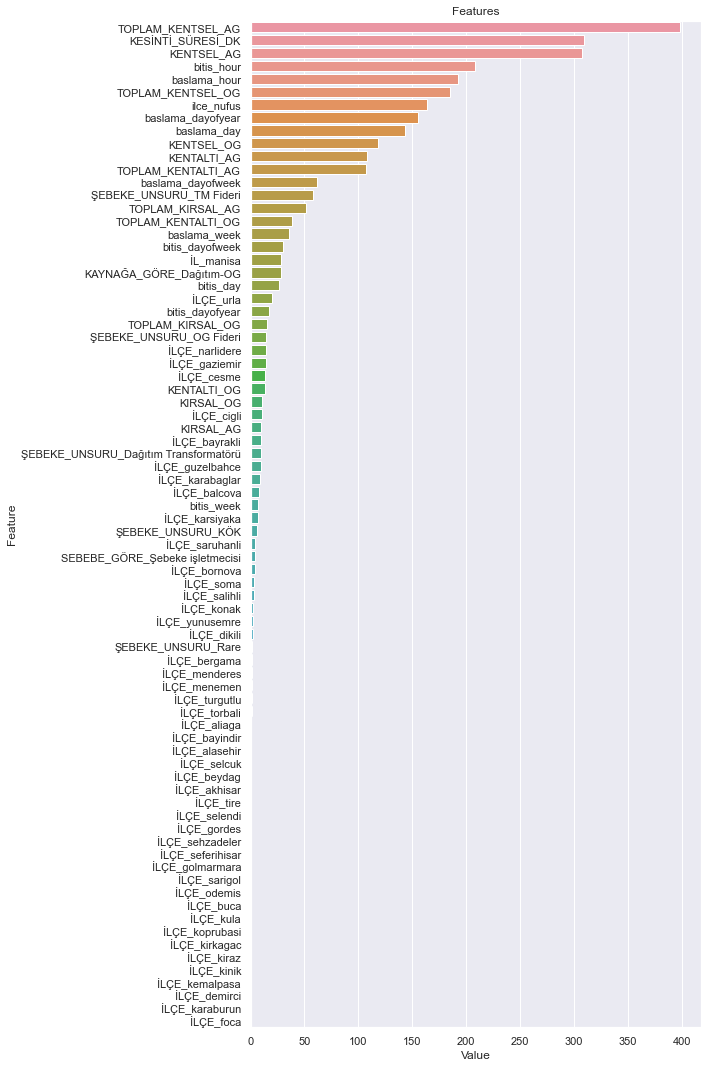

In [183]:
plot_importance(lgbm,X_train,X_train)

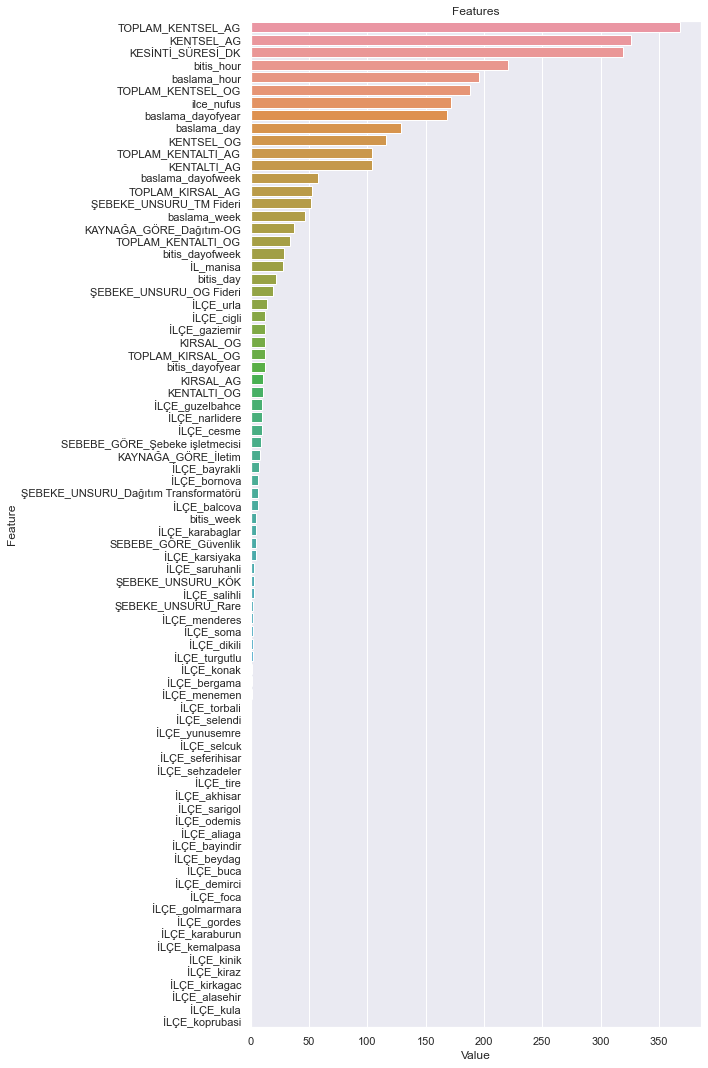

In [100]:
plot_importance(lgbm,X_train,X_train)

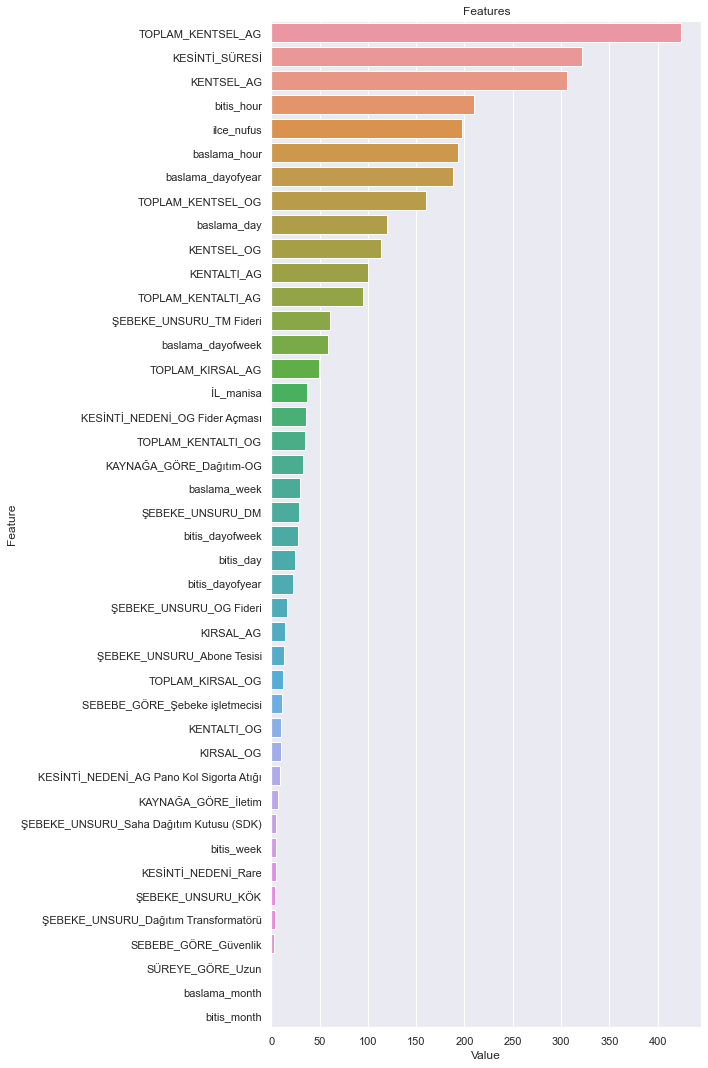

In [125]:
plot_importance(lgbm,X_train,X_train)

In [149]:
#best lgbm
joblib.dump(lgbm,"ilcesiz_model_lgbm.pkl")

['ilcesiz_model_lgbm.pkl']